### Policy Gradients : Actor Critic (Online version i.e learning at each step of episode)
#### Discrete Action Domain

In [10]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym import wrappers
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_actions):
        super(ActorCriticNetwork,self).__init__()
        self.linear1 = nn.Linear(input_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        ## Shared network for actor critic
        self.actor = nn.Linear(hidden_size,n_actions)
        self.critic = nn.Linear(hidden_size,1)
    def forward(self,state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        return F.softmax(self.actor(x),dim=1),self.critic(x)
    


In [12]:
def update_gradients(state,next_state,reward,done,log_prob):
    reward = torch.tensor(reward,dtype=float)
    state.to(device)
    next_state.to(device)
    reward.to(device)
    log_prob.to(device)
    done.to(device)
    ac_optim.zero_grad()
    gamma = 0.99
    _,value_state = ac_net(state)
    _,value_next_state = ac_net(next_state)
    
    td_term = reward + gamma*value_next_state*(1-done) - value_state
    critic_loss = td_term**2
    policy_loss = -td_term*log_prob
    ### Since tensor computational graphs are mapped , this sum of loss will propgate loss accordingly
    loss = critic_loss + policy_loss
    loss.backward()
    ac_optim.step()
    
def train(env,max_episodes,max_steps):
    running_reward = 0
    plot_rewards = []
    for ep in range(max_episodes):
        state = env.reset()
        current_reward = 0
        for step in range(max_steps):
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            prob,_ = ac_net(state)
            ## Sample action from softmax output of network
            dist_object = Categorical(prob)
            sampled_action_tensor = dist_object.sample()
            action_log_prob = dist_object.log_prob(sampled_action_tensor)
            sampled_action = sampled_action_tensor.item()
            
            #Run env
            next_state,reward,done,_ = env.step(sampled_action)
            if done:
                done = 1
            else:
                done = 0
            done = torch.tensor(done)
            #updating grads in online fashion 
            update_gradients(state,torch.from_numpy(next_state).float().unsqueeze(0).to(device),reward,done,action_log_prob)
            
            current_reward += reward
            if done:
                break
            state=next_state
            
            
        running_reward = 0.05 * current_reward + (1 - 0.05) * running_reward
        if ep%100==0:
            print("Running reward = ",running_reward)
        plot_rewards.append(running_reward)
        writer.add_scalar("Reward ",running_reward)
        if running_reward >env.spec.reward_threshold:
            print("Solved in ",ep)
        
    return plot_rewards
        
            
def set_device():
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    print("RUNNING ON ",device)
    return device
                       
            
             
            
    

In [ ]:
device = set_device()
env = gym.make("LunarLander-v2")
env.seed(221)
ac_net = ActorCriticNetwork(8,1024,4).to(device)
ac_optim = optim.Adam(ac_net.parameters(),lr=1e-5)
writer = SummaryWriter()
plot_rewards = train(env,2500,10000)
writer.flush()

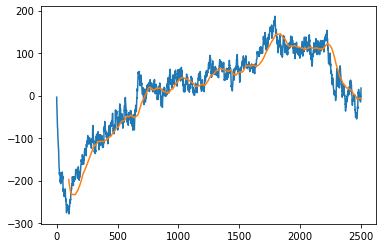

In [14]:
plt.plot(np.arange(0,2500),plot_rewards)
plt.plot(np.arange(0,2500),pd.Series(plot_rewards).rolling(100).mean())
plt.show()